# 4. Final version: GridSearchCV & Feature Selection (Backward Elimination)

01. 이전 버전과 동일한 내용 + 최종 y값 그래프
02. 그리드서치CV를 이용한 최적의 하이퍼파라미터로 튜닝
03. 이후 성능이 좋은 3개의 모델만 후진제거방법으로 피처 셀렉션
04. 최종 모델 결과

## 01-1. import와 모델링 전 컬럼 전처리

In [174]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from model import *

from sklearn.model_selection import learning_curve

In [205]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int64  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  seson_n                       601 non-null    int64  
 13  i_s1_rate 

In [206]:
# 각 범주(나라)의 타겟 변수(여기서는 runtime의 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [207]:
df['production_country_encoded'].unique()

array([ 2.45232951, -0.361577  ,  0.90785554,  1.63489768, -0.76945807,
       -0.78670086,  1.90583598,  2.80439519,  1.03082985,  1.58406362,
        0.98487798,  0.97089936,  1.21292173,  0.64921426,  0.30978595,
       -0.00287019,  0.55313442,  0.38738529,  0.55814685,  1.96116327,
       -0.35728077, -0.50936462,  0.89773096,  0.00619533,  0.49212281,
        0.40019282, -0.41788202, -0.56315303,  0.63014165, -0.14280805,
       -1.64749107])

In [208]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

In [209]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])  # log(1+x) 변환 사용
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

## 01-2. 흥행도 - y값(종속 변수)에 대한 최종 그래프

In [210]:
# y값(흥행도)

# 각 요소 계산
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention']) *10

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

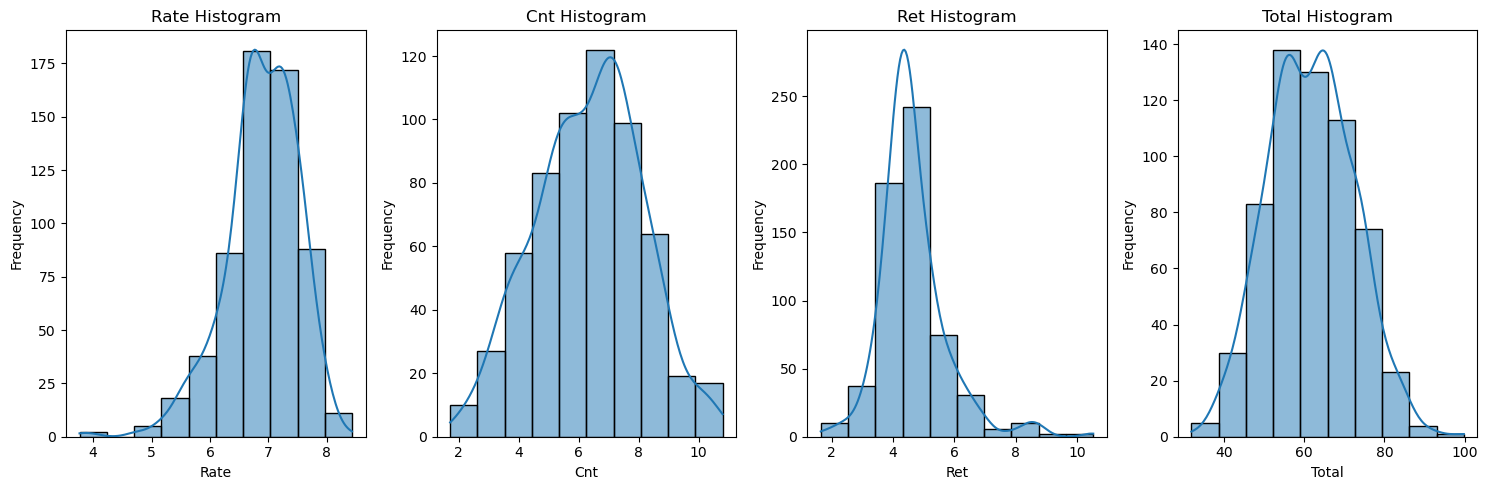

In [211]:
# 히스토그램 그리기
plt.figure(figsize=(15, 5))

# rate 히스토그램
plt.subplot(1, 4, 1)
sns.histplot(rate, bins=10, kde=True)
plt.title('Rate Histogram')
plt.xlabel('Rate')
plt.ylabel('Frequency')

# cnt 히스토그램
plt.subplot(1, 4, 2)
sns.histplot(cnt, bins=10, kde=True)
plt.title('Cnt Histogram')
plt.xlabel('Cnt')
plt.ylabel('Frequency')

# ret 히스토그램
plt.subplot(1, 4, 3)
sns.histplot(ret, bins=10, kde=True)
plt.title('Ret Histogram')
plt.xlabel('Ret')
plt.ylabel('Frequency')

# total 히스토그램
plt.subplot(1, 4, 4)
sns.histplot(total, bins=10, kde=True)
plt.title('Total Histogram')
plt.xlabel('Total')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

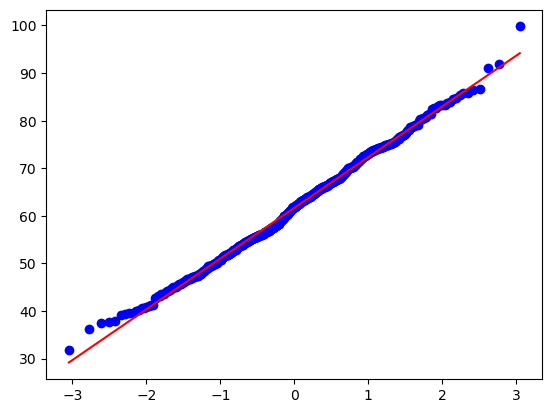

In [212]:
# QQ plot 그리기
stats.probplot(df['score'], dist="norm", plot=plt)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()

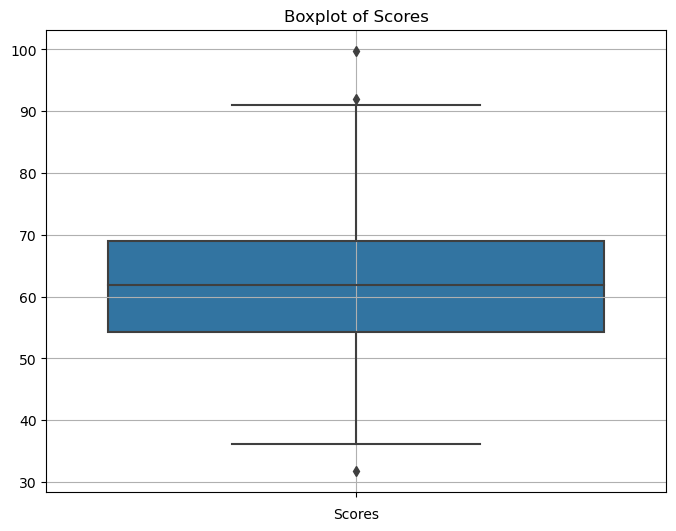

In [213]:
# 박스플롯 그리기
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y="score")
plt.title('Boxplot of Scores')
plt.xlabel('Scores')
plt.ylabel('')
plt.grid(True)
plt.show()

---

## 02-1. GridSearchCV('model.py'이용) 모델링

In [214]:
df_1 = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [215]:
X = df_1.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df_1['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [186]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train, y_train, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train, y_train, **best_params_dt)

# 최적의 모델을 평가합니다
dt_mae, dt_mse, dt_r2 = evaluate(best_dt, X_test, y_test)

model_result = pd.DataFrame({'MAE': [dt_mae], 'MSE': [dt_mse], 'R2': [dt_r2]}, index=['DecisionTreeRegressor'])
print(model_result, best_params_dt)

MAE: 3.154811577429728
MSE: 17.1652756667263
R^2: 0.8357209411826646
                            MAE        MSE        R2
DecisionTreeRegressor  3.154812  17.165276  0.835721 {'max_depth': 5, 'min_samples_split': 25}


{'runtime': 0.0, 'genre': 0.0, 'age_rating': 0.0, 'production_country_encoded': 0.0, 'PCA': 0.015735179792250142, 'genre_len': 0.0, 'seson_n': 0.0, 'i_s1_rate': 0.03450645875641314, 'i_s1_rate_cnt': 0.9084520626496455, 's1_rate_retention': 0.0, 's1_rate_cnt_retention': 0.0, 'w_s1_rate': 0.020817659552473968, 'w_s1_rate_cnt': 0.020488639249217323, 's1_gap_days': 0.0, 'season_gaps_days': 0.0}


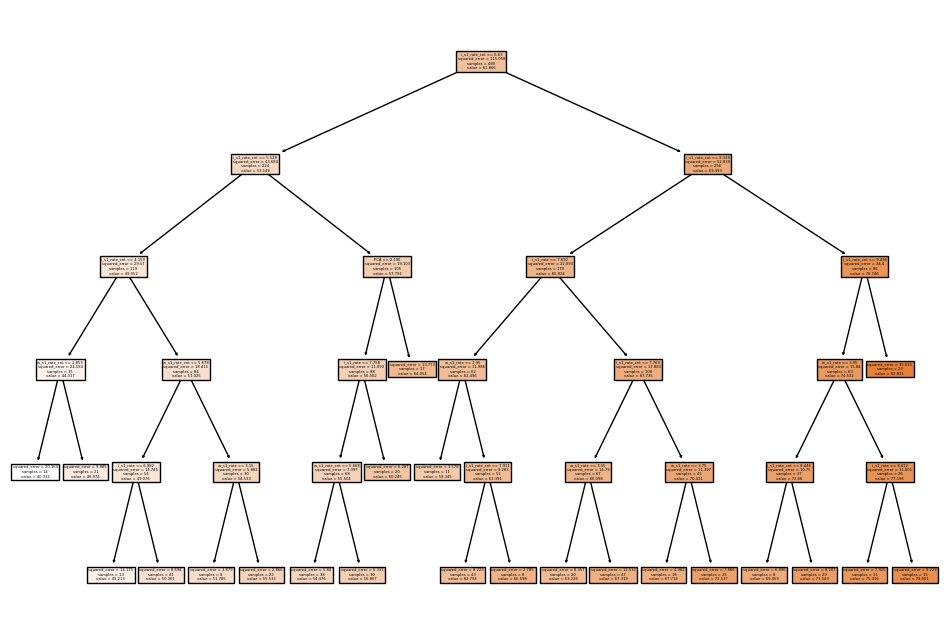

In [187]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 특성 중요도를 확인합니다
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리를 시각화합니다
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()

In [188]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train, y_train, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train, y_train, **best_params_rf)

# 최적의 모델을 평가합니다
rf_mae, rf_mse , rf_r2 = evaluate(best_rf, X_test, y_test)

model_result = pd.DataFrame({'MAE': [rf_mae], 'MSE': [rf_mse], 'R2': [rf_r2]}, index=['RandomForestRegressor'])
print(model_result, best_params_rf)

MAE: 2.5535591360657803
MSE: 11.806760255226932
R^2: 0.8870042345914438
                            MAE       MSE        R2
RandomForestRegressor  2.553559  11.80676  0.887004 {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [189]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train, y_train, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train, y_train, **best_params_knn)

# 최적의 모델을 평가합니다
knn_mae, knn_mse , knn_r2 = evaluate(best_knn, X_test, y_test)

model_result = pd.DataFrame({'MAE': [knn_mae], 'MSE': [knn_mse], 'R2': [knn_r2]}, index=['RandomForestRegressor'])
print(model_result, best_params_knn)

MAE: 3.239243174254563
MSE: 17.03605740974353
R^2: 0.8369576153876874
                            MAE        MSE        R2
RandomForestRegressor  3.239243  17.036057  0.836958 {'n_neighbors': 5, 'weights': 'distance'}


In [190]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train, y_train, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train, y_train, **best_params_xgb)

# 최적의 모델을 평가합니다
xgb_mae, xgb_mse, xgb_r2 = evaluate(best_xgb, X_test, y_test)
print(best_model_xgb, best_params_xgb)

MAE: 2.572536148383339
MSE: 11.172619411580339
R^2: 0.8930732347621683
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...) {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


{'runtime': 0.0018263033, 'genre': 0.014975957, 'age_rating': 0.00052545953, 'production_country_encoded': 0.022749675, 'PCA': 0.11791059, 'genre_len': 0.009519898, 'seson_n': 0.0111886095, 'i_s1_rate': 0.043499306, 'i_s1_rate_cnt': 0.63127244, 's1_rate_retention': 0.0076507297, 's1_rate_cnt_retention': 0.011186754, 'w_s1_rate': 0.045771193, 'w_s1_rate_cnt': 0.06090169, 's1_gap_days': 0.010842013, 'season_gaps_days': 0.010179314}


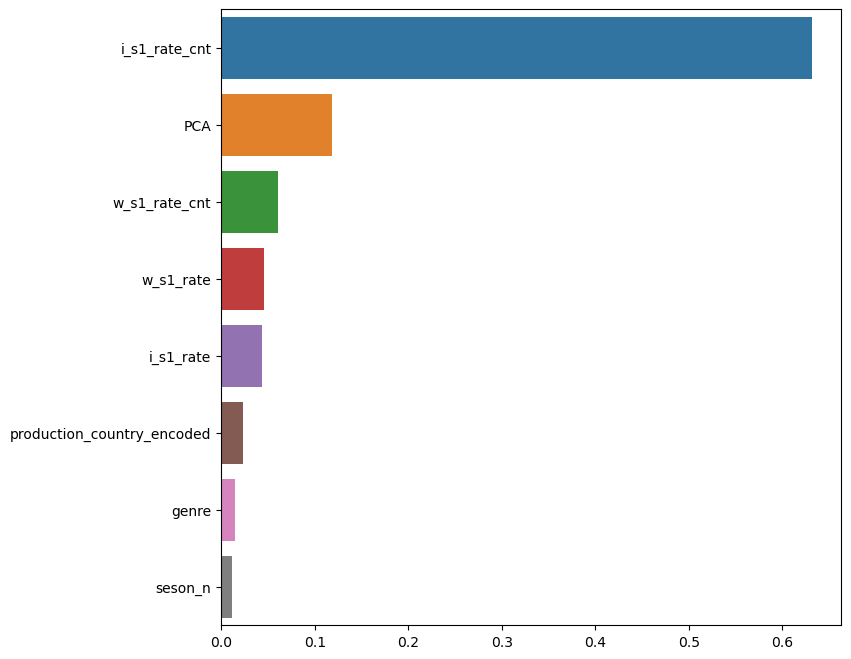

In [191]:
# 특성 중요도를 확인합니다
feature_importances_xgb = best_xgb.feature_importances_
importances_dict = dict(zip(X_train.columns, best_xgb.feature_importances_))
print(importances_dict)

best_cols= pd.Series(feature_importances_xgb, index=X.columns)
top_cols = best_cols.sort_values(ascending=False)[:8]     #5개 컬럼만

plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

In [192]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train, y_train, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_xgb(X_train, y_train, **best_params_ada)

# 최적의 모델을 평가합니다
ada_mae, ada_mse, ada_r2 = evaluate(best_ada, X_test, y_test)
print(best_model_ada, best_params_ada)

MAE: 2.754126629921858
MSE: 13.252506530146695
R^2: 0.8731678219439688
AdaBoostRegressor(learning_rate=0.2, n_estimators=200, random_state=13) {'learning_rate': 0.2, 'n_estimators': 200}


In [ ]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train, y_train, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train, y_train, **best_params_lgb)

# 최적의 모델을 평가합니다
lgb_mae, lgb_mse, lgb_r2 = evaluate(best_lgb, X_test, y_test)
print(best_model_lgb, best_params_lgb)

In [194]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train, y_train, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train, y_train, **best_params_gbm)

# 최적의 모델을 평가합니다
gbm_mae, gbm_rmse, gbm_r2 = evaluate(best_gbm, X_test, y_test)
print(best_model_gbm, best_params_gbm)

MAE: 2.47120282646626
MSE: 10.665251101680518
R^2: 0.8979289673494201
GradientBoostingRegressor(n_estimators=50, random_state=13) {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [195]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

model_result = pd.DataFrame({'MSE': [lr_mse], 'MAE': [lr_mae], 'R2': [lr_r2]}, index=['LinearRegression'])

C:\Users\rbfl7\AppData\Local\Temp\ipykernel_25564\2482172276.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals.values, shade=True)


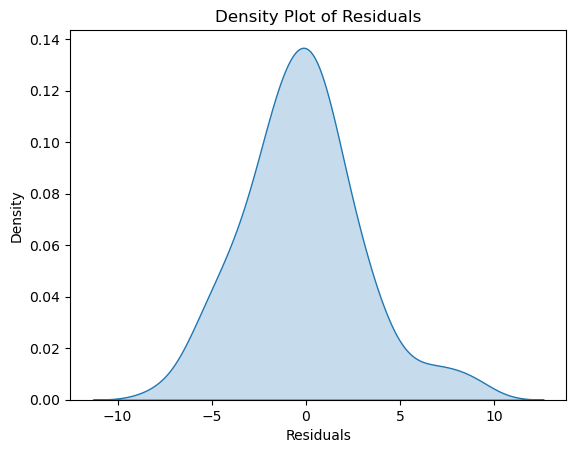

In [196]:
# 잔차를 계산합니다.
residuals = y_test - lr_predictions

# 밀도 플롯을 생성합니다.
sns.kdeplot(residuals.values, shade=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

- 잔차의 분포가 정규화를 따름

---

## 02-2 최적의 하이퍼파라미터 튜닝 후 성능 결과

In [197]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgb_mse, gbm_rmse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgb_mae, gbm_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgb_r2, gbm_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor      17.165276  3.154812  0.835721
RandomForestRegressor      11.806760  2.553559  0.887004
KNeighborsRegressor        17.036057  3.239243  0.836958
XGBoostRegressor           11.172619  2.572536  0.893073
AdaBoostRegressor          13.252507  2.754127  0.873168
LightGBMRegressor          10.838822  2.523156  0.896268
GradientBoostingRegressor  10.665251  2.471203  0.897929
LinearRegression            9.598203  2.363427  0.908141


In [198]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor  10.665251  2.471203  0.897929
LightGBMRegressor          10.838822  2.523156  0.896268
 
MAE 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor  10.665251  2.471203  0.897929
LightGBMRegressor          10.838822  2.523156  0.896268
 
R2 기준
                                 MSE       MAE        R2
LinearRegression            9.598203  2.363427  0.908141
GradientBoostingRegressor  10.665251  2.471203  0.897929
LightGBMRegressor          10.838822  2.523156  0.896268


---

## 03-1. Feature Selection과 결과 그래프
- GradientBoostingRegressor, LightGBMRegressor 모델 각각 피쳐셀렉션 진행
- 피쳐셀렉션 후 GradientBoostingRegressor의 그래프, 예측 결과와 실제 결과를 비교

In [199]:
# 후진 제거 피처 셀렉션 함수
def backward_elimination(model, X_train, y_train, X_test, y_test):
    features = X_train.columns.tolist()
    best_mse = mean_squared_error(y_test, model.fit(X_train, y_train).predict(X_test))
    best_features = features.copy()

    for feature in features:
        temp_features = best_features.copy()
        temp_features.remove(feature)
        
        X_train_temp, X_test_temp = X_train[temp_features], X_test[temp_features]
        model.fit(X_train_temp, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test_temp))
        
        if mse <= best_mse:
            best_mse = mse
            best_features = temp_features

    return best_mse, best_features

# GradientBoostingRegressor에 후진 제거 적용
gbr_mse_fs, gbr_selected_features = backward_elimination(best_gbm, X_train, y_train, X_test, y_test)
print(f"GradientBoostingRegressor Best MSE: {gbr_mse_fs}")
print(f"Selected Features: {gbr_selected_features}")

# LGBMRegressor에 후진 제거 적용
lgb_mse_fs, lgb_selected_features = backward_elimination(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMRegressor Best MSE: {lgb_mse_fs}")
print(f"Selected Features: {lgb_selected_features}")

GradientBoostingRegressor Best MSE: 9.766437395146555
Selected Features: ['runtime', 'genre', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 15
[LightGBM] [Info] Start training from score 61.865731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [200]:
# 선택된 피처
gbr_features = ['runtime', 'genre', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
lgb_features = ['genre', 'production_country_encoded', 'genre_len', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']

# 학습 및 평가 데이터 준비
X_train_gbr = X_train[gbr_features]
X_test_gbr = X_test[gbr_features]

X_train_lgb = X_train[lgb_features]
X_test_lgb = X_test[lgb_features]

In [201]:
# GradientBoostingRegressor 모델 평가
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50, random_state=13, max_depth=3)
gbr.fit(X_train_gbr, y_train)
y_pred_gbr = gbr.predict(X_test_gbr)

gbr_mse_fs = mean_squared_error(y_test, y_pred_gbr)
gbr_mae_fs = mean_absolute_error(y_test, y_pred_gbr)
gbr_r2_fs = r2_score(y_test, y_pred_gbr)

print(f"GradientBoostingRegressor MSE: {gbr_mse_fs}")
print(f"GradientBoostingRegressor MAE: {gbr_mae_fs}")
print(f"GradientBoostingRegressor R^2: {gbr_r2_fs}")

# LGBMRegressor 모델 평가
lgb = LGBMRegressor(learning_rate=0.1, n_estimators=50, random_state=13, max_depth=3)
lgb.fit(X_train_lgb, y_train)
y_pred_lgb = lgb.predict(X_test_lgb)

lgb_mse_fs = mean_squared_error(y_test, y_pred_lgb)
lgb_mae_fs = mean_absolute_error(y_test, y_pred_lgb)
lgb_r2_fs = r2_score(y_test, y_pred_lgb)

print(f"LGBMRegressor MSE: {lgb_mse_fs}")
print(f"LGBMRegressor MAE: {lgb_mae_fs}")
print(f"LGBMRegressor R^2: {lgb_r2_fs}")

GradientBoostingRegressor MSE: 9.766437395146555
GradientBoostingRegressor MAE: 2.3869075899502636
GradientBoostingRegressor R^2: 0.9065310004672302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 11
[LightGBM] [Info] Start training from score 61.865731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

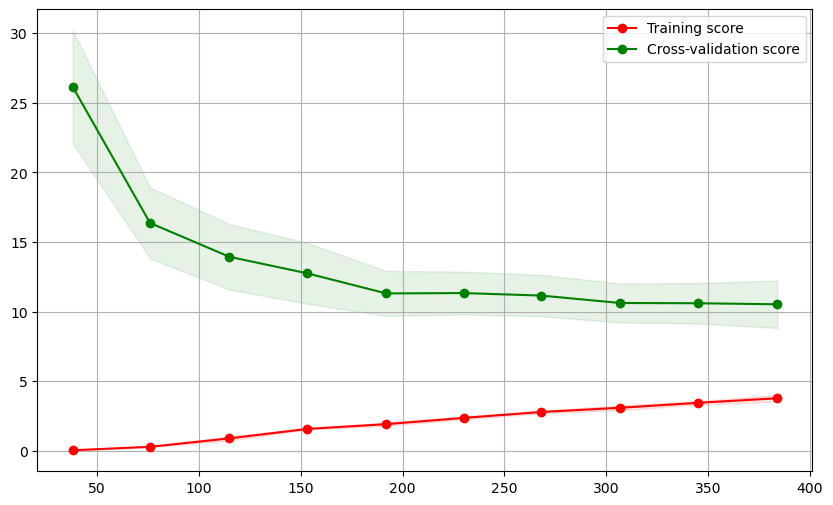

In [202]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    gbr, X_train_gbr, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.legend(loc="best")
plt.grid()
plt.show()

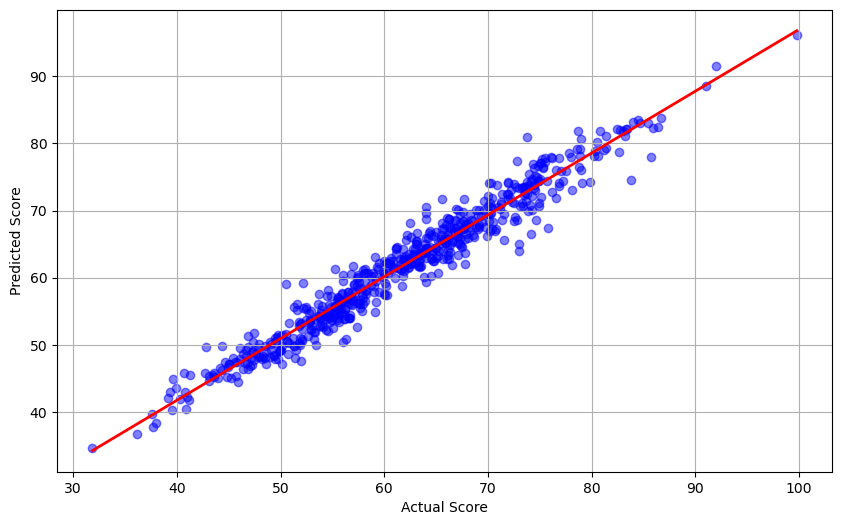

In [203]:
# GradientBoostingRegressor 모델 초기화
gbr_model = GradientBoostingRegressor(**best_params_gbm, random_state=13)

# 모델 학습
gbr_model.fit(X_train[gbr_features], y_train)

# 예측값 계산
y_train_pred = gbr_model.predict(X_train[gbr_features])
y_test_pred = gbr_model.predict(X_test[gbr_features])

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train[gbr_features], X_test[gbr_features]))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

In [216]:
# 예측 결과와 실제 결과를 비교
comparison_df = pd.DataFrame({
        'korean_title': df['korean_title'],
        'season_num':df['seson_n'],
        'actual': df['score'],
        'predicted': y_combined_pred,
        'diff': df['score'] - y_combined_pred
    })

In [217]:
comparison_df.head()

,korean_title,season_num,actual,predicted,diff
0,스위트 투스: 사슴뿔을 가진 소년,2,61.094158,68.442019,-7.347861
1,스위트홈,2,56.779563,74.455988,-17.676426
2,굿 닥터,2,70.162418,48.581673,21.580745
3,워킹 데드,2,83.368287,56.743412,26.624875
4,"비르기트: 왕국, 권력, 영광",2,58.998126,63.876940,-4.878814


---

## 03-2. LinearRegression의 Feature Selection의 결과
- LinearRegression는 피처셀렉션 이후 성능이 더 안 좋아졌기에 그 전 버전으로 그대로 사용

In [218]:
import statsmodels.api as sm

# 상수항 추가
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Backward Elimination 수행 함수
def backward_elimination_ls(X, y, significance_level=0.05):
    while True:
        regressor_OLS = sm.OLS(y, X).fit()
        max_p_value = max(regressor_OLS.pvalues)
        if max_p_value > significance_level:
            excluded_feature = regressor_OLS.pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
    return X

# 훈련 데이터에 대해 Backward Elimination 수행
X_train_opt = backward_elimination_ls(X_train_const, y_train, significance_level=0.05)

# 최적 모델로 테스트 데이터 예측
lr_model_opt = LinearRegression()
lr_model_opt.fit(X_train_opt, y_train)
X_test_opt = X_test_const[X_train_opt.columns]  # 선택된 특성으로 테스트 데이터 준비
y_pred_opt = lr_model_opt.predict(X_test_opt)

# 모델의 성능 평가
lr_mse_fs = mean_squared_error(y_test, y_pred_opt)
lr_mae_fs = mean_absolute_error(y_test, y_pred_opt)
lr_r2_fs = r2_score(y_test, y_pred_opt)

# 성능 평가 결과 출력
model_result_opt = pd.DataFrame({
    'MSE': [lr_mse_fs],
    'MAE': [lr_mae_fs],
    'R2': [lr_r2_fs]
}, index=['Optimized LinearRegression'])

print("Backward Elimination 후 최적 모델의 성능 평가 결과:")
print(model_result_opt)
# 선택된 특성들 출력
print("선택된 특성들:")
print(X_train_opt.columns)


Backward Elimination 후 최적 모델의 성능 평가 결과:
                                 MSE       MAE        R2
Optimized LinearRegression  9.902615  2.405728  0.905228
선택된 특성들:
Index(['genre', 'PCA', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt',
       's1_rate_retention', 's1_rate_cnt_retention', 'w_s1_rate',
       'w_s1_rate_cnt', 'season_gaps_days'],
      dtype='object')


---

## 04. 최종 모델 결과(LinearRegression)와 그래프(+예측 결과와 실제 결과를 비교)

In [219]:
model_result = pd.DataFrame({
    'MSE': [lr_mse,gbr_mse_fs, lgb_mse_fs],
    'MAE': [lr_mae, gbr_mae_fs, lgb_mae_fs],
    'R2': [lr_r2, gbr_r2_fs, lgb_r2]
}, index=['LinearRegression', 'GradientBoostingRegressor', 'LightGBMRegressor'])
print(model_result)

                                MSE       MAE        R2
LinearRegression           9.598203  2.363427  0.908141
GradientBoostingRegressor  9.766437  2.386908  0.906531
LightGBMRegressor          9.996742  2.420154  0.896268


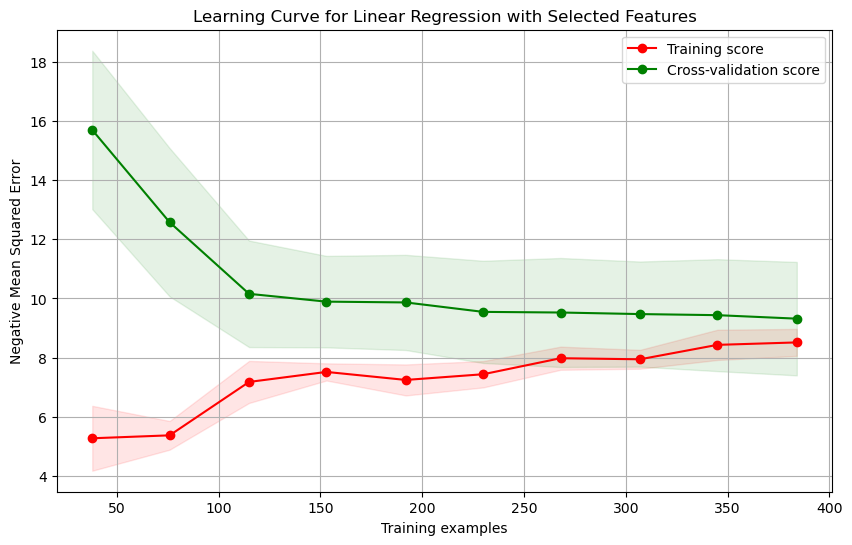

In [220]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression with Selected Features')
plt.legend(loc="best")
plt.grid()
plt.show()

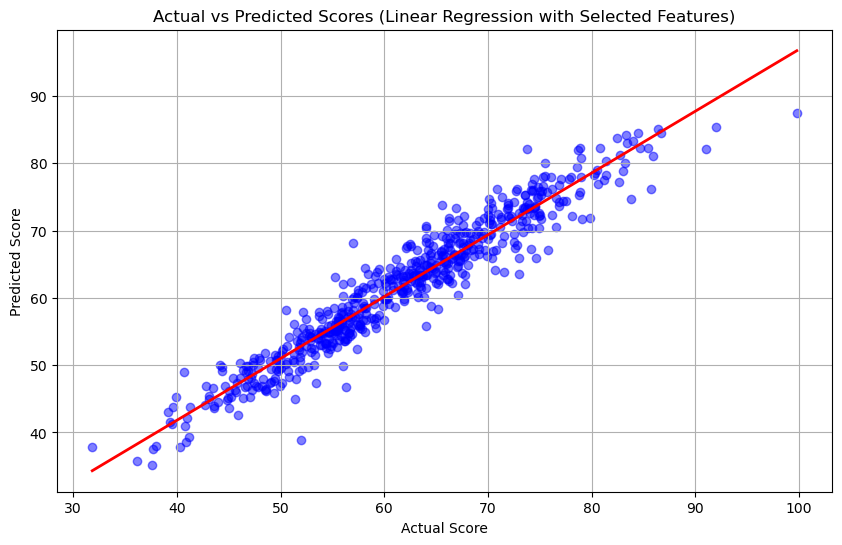

In [221]:
# 예측값 계산
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Linear Regression with Selected Features)')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

In [222]:
# 예측 결과와 실제 결과를 비교
comparison_df = pd.DataFrame({
        'korean_title': df['korean_title'],
        'season_num':df['seson_n'],
        'actual': df['score'],
        'predicted': y_combined_pred,
        'diff': df['score'] - y_combined_pred
    })

In [223]:
comparison_df.head()

,korean_title,season_num,actual,predicted,diff
0,스위트 투스: 사슴뿔을 가진 소년,2,61.094158,68.197938,-7.103780
1,스위트홈,2,56.779563,76.091322,-19.311759
2,굿 닥터,2,70.162418,49.343007,20.819411
3,워킹 데드,2,83.368287,57.583005,25.785282
4,"비르기트: 왕국, 권력, 영광",2,58.998126,63.249860,-4.251734


---